# 필요한 모듈 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.datasets as dsets
from torch.autograd import Variable
import torch.nn.functional as F
import scipy as sp
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline

import os
import random
import numpy as np
import pickle

# 데이터 불러오기

In [3]:
transform = transforms.Compose([          
        transforms.ToTensor(),                     
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

cudnn.benchmark = True

train_dataset = dsets.MNIST(root='./data/', train=True, download=True, transform=transform) 
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

In [4]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        
        self.fc = nn.Sequential(
                
                    nn.Linear(74,1024),
                    nn.BatchNorm1d(1024),
                    nn.LeakyReLU(0.1),
                    nn.Linear(1024,7*7*128),
                    nn.BatchNorm1d(7*7*128),
                    nn.LeakyReLU(0.1)

                )
        
        self.conv = nn.Sequential(
            
                    nn.ConvTranspose2d(128, 64, kernel_size=4,stride=2,padding=1),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU(0.1),
                    nn.ConvTranspose2d(64, 1, kernel_size=4,stride=2,padding=1),

        )


        
    def forward(self, x):
        
        x = self.fc(x)

        x = x.view(batchSize,128,7,7)
        
        x = self.conv(x)

        return x

Hout=(Hin−1)∗stride[0]−2∗padding[0]+kernel_size[0]+output_padding[0]

In [8]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.conv = nn.Sequential(
                    
                    nn.Conv2d(1, 64, kernel_size=4,stride=2,padding=1),
                    nn.LeakyReLU(0.1),
                    nn.Conv2d(64, 128, kernel_size=4,stride=2,padding=1),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU(0.1)
        
        )
        
        self.fc1 = nn.Sequential(
        
                    nn.Linear(6272, 1024),
                    nn.BatchNorm1d(1024),
                    nn.LeakyReLU(0.1),
        )

        self.fc2 = nn.Linear(1024,1)
        
    def forward(self, x):

        x = self.conv(x)

        x = self.fc1(x.view(batchSize,-1))
        
        out_logit = self.fc2(x)
        
        out = F.sigmoid(out_logit)
        
        
        return out, out_logit, x

In [9]:
class _netQ(nn.Module):
    def __init__(self):
        super(_netQ, self).__init__()

        self.fc1  = nn.Sequential(
                    
                    nn.Linear(1024,64),
                    nn.BatchNorm1d(64),
                    nn.LeakyReLU(0.1)
        )
        
        self.fc2 = nn.Linear(64,12)

    def forward(self, x):
        
        x = self.fc1(x)
        
        out_logit = self.fc2(x)
        
        out = F.softmax(out_logit)
        
        

        return out, out_logit

# 파라미터 초기값 설정

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# 네트워크 초기화

In [27]:
netG = _netG()
netG.apply(weights_init)

print(netG)

_netG (
  (fc): Sequential (
    (0): Linear (74 -> 1024)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.1)
    (3): Linear (1024 -> 6272)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True)
    (5): LeakyReLU (0.1)
  )
  (conv): Sequential (
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.1)
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)


In [28]:
netD = _netD()
netD.apply(weights_init)

print(netD)

_netD (
  (conv): Sequential (
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU (0.1)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.1)
  )
  (fc1): Sequential (
    (0): Linear (6272 -> 1024)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.1)
  )
  (fc2): Linear (1024 -> 1)
)


In [29]:
netQ = _netQ()
netQ.apply(weights_init)

print(netQ)

_netQ (
  (fc1): Sequential (
    (0): Linear (1024 -> 64)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.1)
  )
  (fc2): Linear (64 -> 12)
)


# 기타 다른 초기값 세팅

In [30]:
niter = 200
batchSize = 100
imageSize = 28
nz = 62

input = torch.FloatTensor(batchSize, 3, imageSize,imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)

label = torch.FloatTensor(batchSize,1).cuda()
real_label = 1.0
fake_label = 0.0

In [47]:
noise = torch.FloatTensor(batchSize, nz, 1, 1)

In [31]:
input = input.cuda()

In [32]:
netQ.cuda()
netD.cuda()
netG.cuda()

_netG (
  (fc): Sequential (
    (0): Linear (74 -> 1024)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.1)
    (3): Linear (1024 -> 6272)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True)
    (5): LeakyReLU (0.1)
  )
  (conv): Sequential (
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.1)
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

# Loss 기준 및 Optimizer

In [33]:
import itertools

In [34]:
criterion1 = nn.BCELoss().cuda()
criterion2 = nn.CrossEntropyLoss().cuda()
criterion3 = nn.MSELoss().cuda()

beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=2e-4, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=1e-3, betas=(beta1, 0.999))
optimizerQ = optim.Adam(itertools.chain(netD.parameters(),netG.parameters(),netQ.parameters()), lr=1e-3, betas=(beta1, 0.999))

# Sampling 함수들

In [35]:
def sample_disc(size):
    sampleClass = np.random.randint(0,10,100).astype(int)
    sample = np.zeros((100,10))
    for i in range(100):
        sample[i][sampleClass[i]-1] = 1
    return sampleClass, sample

In [36]:
def sample_cont(size):
    return np.random.uniform(-1,1,size=size).astype(float)

# loss / score 담을 변수

In [37]:
result_dict = {}
loss_D = []
loss_G = []
loss_Q = []
score_D = []
score_G = []

loss_d:1.422204613685608, loss_G:0.78081876039505, loss_Q:2.7529296875, score_D:0.47483304142951965, score_G:0.47768634557724

loss_d:1.234119176864624, loss_G:0.7215467691421509, loss_Q:2.3824942111968994, score_D:0.5517196655273438, score_G:0.4649568200111389
loss_d:1.2590413093566895, loss_G:0.6997889876365662, loss_Q:2.2763094902038574, score_D:0.5404437780380249, score_G:0.46806350350379944
loss_d:1.2676353454589844, loss_G:0.7163914442062378, loss_Q:2.1005637645721436, score_D:0.5414096713066101, score_G:0.47016167640686035
loss_d:1.2657561302185059, loss_G:0.7058756947517395, loss_Q:2.105767011642456, score_D:0.5474606156349182, score_G:0.47539082169532776
loss_d:1.296898365020752, loss_G:0.7096178531646729, loss_Q:2.037484645843506, score_D:0.5180235505104065, score_G:0.46232104301452637



loss_d:1.2795939445495605, loss_G:0.7134254574775696, loss_Q:1.8951107263565063, score_D:0.5290449857711792, score_G:0.465017169713974
loss_d:1.284642219543457, loss_G:0.7185337543487549, loss_Q:1.7639801502227783, score_D:0.522872269153595, score_G:0.45983588695526123
loss_d:1.3169918060302734, loss_G:0.7011196613311768, loss_Q:1.6754318475723267, score_D:0.5265923142433167, score_G:0.4823814034461975
loss_d:1.3334094285964966, loss_G:0.6902154684066772, loss_Q:1.6014902591705322, score_D:0.5208472609519958, score_G:0.4836602509021759
loss_d:1.3347690105438232, loss_G:0.6985944509506226, loss_Q:1.5755488872528076, score_D:0.5268200635910034, score_G:0.4893522560596466
loss_d:1.322002649307251, loss_G:0.7099401950836182, loss_Q:1.5290398597717285, score_D:0.5226218104362488, score_G:0.4805605411529541



loss_d:1.322148084640503, loss_G:0.7016357183456421, loss_Q:1.5553598403930664, score_D:0.5269090533256531, score_G:0.4860486686229706
loss_d:1.3015079498291016, loss_G:0.7188547253608704, loss_Q:1.5142085552215576, score_D:0.5339998006820679, score_G:0.4798491299152374
loss_d:1.3291749954223633, loss_G:0.7036152482032776, loss_Q:1.5392944812774658, score_D:0.52872633934021, score_G:0.4888181984424591
loss_d:1.2898035049438477, loss_G:0.7477555871009827, loss_Q:1.5536760091781616, score_D:0.525147557258606, score_G:0.46271607279777527
loss_d:1.2741658687591553, loss_G:0.7380023002624512, loss_Q:1.5059939622879028, score_D:0.528084933757782, score_G:0.46105557680130005
loss_d:1.2818794250488281, loss_G:0.7243608236312866, loss_Q:1.516480565071106, score_D:0.5373749732971191, score_G:0.4740949869155884



loss_d:1.243138074874878, loss_G:0.7550124526023865, loss_Q:1.5092378854751587, score_D:0.5366761684417725, score_G:0.4516206383705139
loss_d:1.2091044187545776, loss_G:0.7419874668121338, loss_Q:1.5534952878952026, score_D:0.5589706301689148, score_G:0.45380401611328125
loss_d:1.1856486797332764, loss_G:0.7675011157989502, loss_Q:1.5073961019515991, score_D:0.5644828677177429, score_G:0.4459074139595032


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


loss_d:1.1991949081420898, loss_G:0.7802785634994507, loss_Q:1.4905909299850464, score_D:0.5654736757278442, score_G:0.4524519443511963
loss_d:1.2005964517593384, loss_G:0.7764379382133484, loss_Q:1.518812656402588, score_D:0.5556585192680359, score_G:0.4381153881549835
loss_d:1.155355453491211, loss_G:0.8120844960212708, loss_Q:1.4892796277999878, score_D:0.5625431537628174, score_G:0.42151904106140137



loss_d:1.1650140285491943, loss_G:0.7841249108314514, loss_Q:1.5435651540756226, score_D:0.5856706500053406, score_G:0.45201602578163147
loss_d:1.1578388214111328, loss_G:0.8014547824859619, loss_Q:1.499516248703003, score_D:0.5686956644058228, score_G:0.4339810609817505
loss_d:1.2202305793762207, loss_G:0.7453790903091431, loss_Q:1.5051140785217285, score_D:0.5742971897125244, score_G:0.4563847780227661
loss_d:1.1330857276916504, loss_G:0.8069871664047241, loss_Q:1.4963126182556152, score_D:0.5672991275787354, score_G:0.41303664445877075
loss_d:1.1508934497833252, loss_G:0.7603050470352173, loss_Q:1.5002206563949585, score_D:0.5757330060005188, score_G:0.42682358622550964
loss_d:1.1571967601776123, loss_G:0.7921145558357239, loss_Q:1.48211669921875, score_D:0.5828949809074402, score_G:0.4408307373523712



loss_d:1.164294719696045, loss_G:0.7822828888893127, loss_Q:1.4951279163360596, score_D:0.5636579990386963, score_G:0.4260292053222656
loss_d:1.1474497318267822, loss_G:0.7851914763450623, loss_Q:1.486458659172058, score_D:0.5714982748031616, score_G:0.42322513461112976
loss_d:1.1160356998443604, loss_G:0.8291623592376709, loss_Q:1.4958410263061523, score_D:0.5828483700752258, score_G:0.41264355182647705
loss_d:1.1474533081054688, loss_G:0.7987992167472839, loss_Q:1.4850083589553833, score_D:0.5690574049949646, score_G:0.42019444704055786
loss_d:1.1327354907989502, loss_G:0.7901551723480225, loss_Q:1.4881198406219482, score_D:0.5685030817985535, score_G:0.4095083475112915
loss_d:1.112854242324829, loss_G:0.7986509799957275, loss_Q:1.4933984279632568, score_D:0.6028563976287842, score_G:0.4342048764228821


KeyboardInterrupt: 

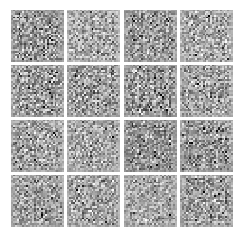

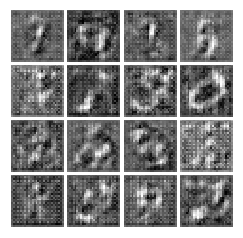

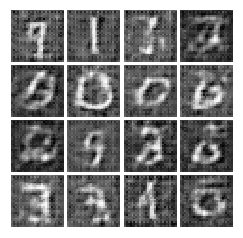

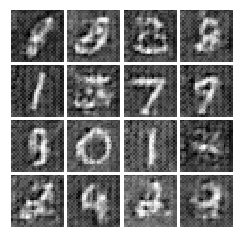

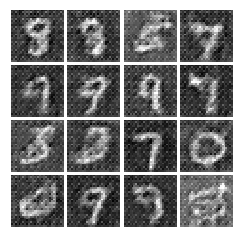

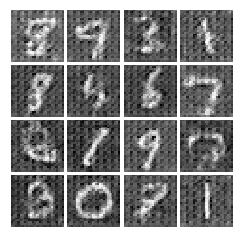

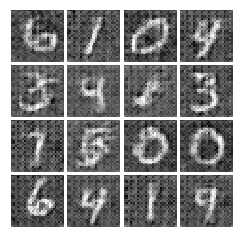

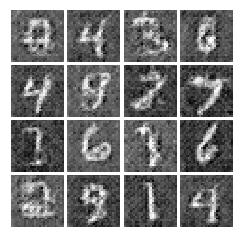

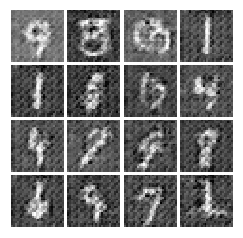

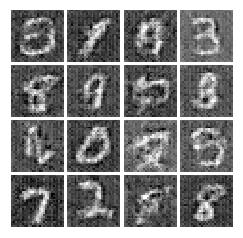

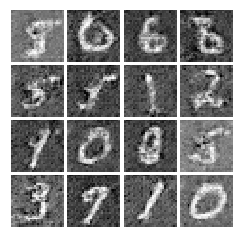

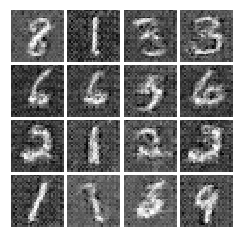

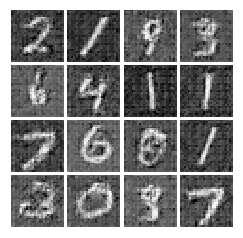

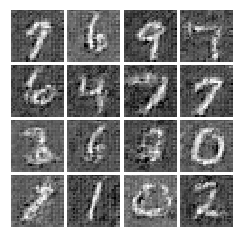

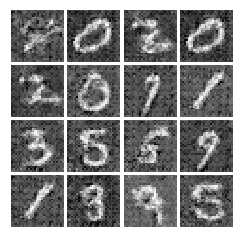

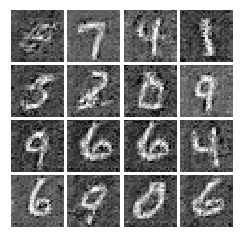

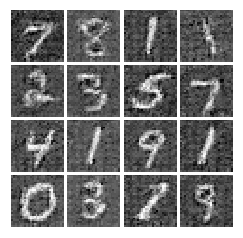

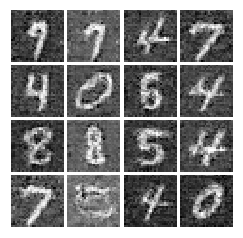

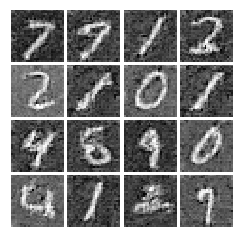

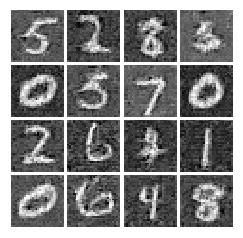

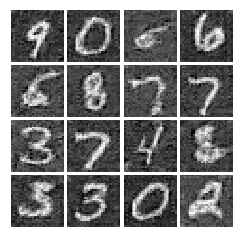

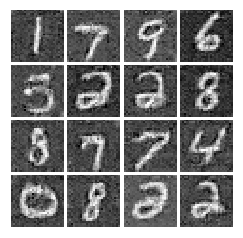

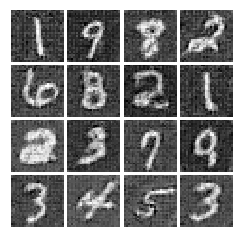

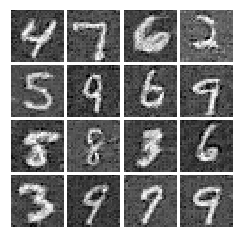

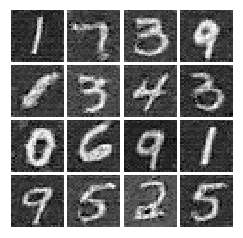

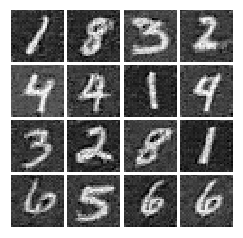

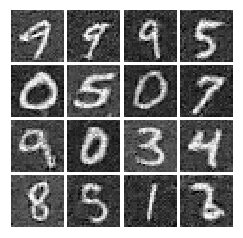

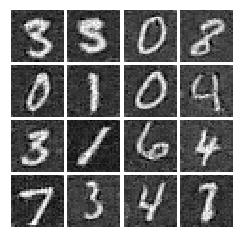

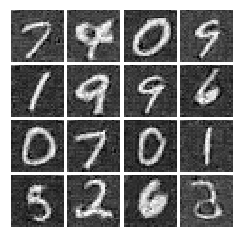

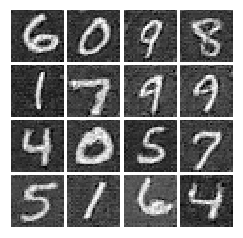

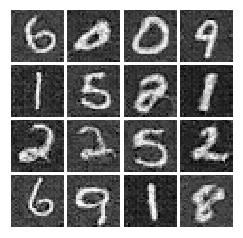

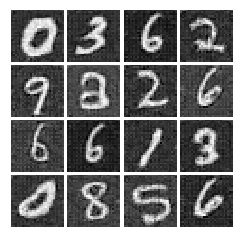

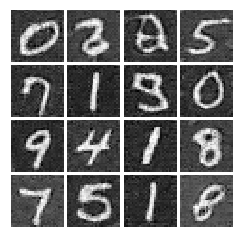

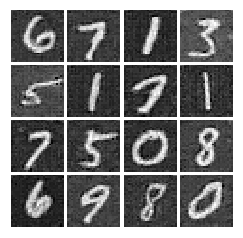

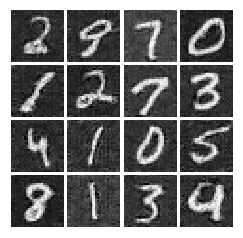

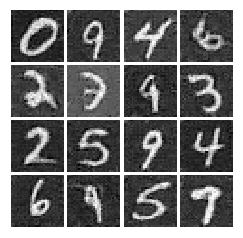

In [38]:
niter = 200


for epoch in range(niter):
    for i, data in enumerate(tqdm_notebook(data_loader)):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)

        real_cpu = real_cpu.cuda()
        
        
        inputv = Variable(real_cpu)
        labelv = Variable(label.fill_(real_label))
        output,_,_ = netD(inputv)
        

        errD_real = criterion1(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()
        

        
        # train with fake
        noise.resize_(batchSize, nz).normal_(0, 1)
        
        
        c_disc_class,c1 = sample_disc(batchSize)
        c_disc_class = torch.LongTensor(c_disc_class)
        c1 = torch.FloatTensor(c1)
        c2 = sample_cont(batchSize).reshape(batchSize,1)
        c2 = torch.FloatTensor(c2)
        c3 = sample_cont(batchSize).reshape(batchSize,1)
        c3 = torch.FloatTensor(c3)
        
        c_disc = c1.type(torch.FloatTensor)
        c_cont = torch.cat([c2,c3],1)
        c = torch.cat([c_disc,c_cont],1)
        
        noisev = Variable(torch.cat([noise,c],1).cuda())
        
        fake = netG(noisev)

        labelv = Variable(label.fill_(fake_label))
        output,_,_ = netD(fake.detach())

        errD_fake = criterion1(output, labelv)

        D_G_z = output.data.mean()
        errD_fake.backward()
        errD = errD_fake + errD_real

        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ############################
        
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output,_,_ = netD(fake)
        errG = criterion1(output, labelv)
        errG.backward()
        optimizerG.step()
        
        
        ############################
        # (3) Update G network again to ensure that errD doesn't go zero
        ############################
        
        fake = netG(noisev)
        
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output,_,_ = netD(fake)
        errG = criterion1(output, labelv)
        errG.backward()
        optimizerG.step()

         
        ############################
        # (4) Update Q network       
        ############################
        fake = netG(noisev)
        _,_,output = netD(fake)
        c_logit_fake, c_fake = netQ(output)        
        netQ.zero_grad()
        netD.zero_grad()
        netG.zero_grad()

        c_disc_est = c_logit_fake[:, :10]
        q_disc_loss = criterion2(c_disc_est,Variable(c_disc_class.cuda()))

        
        c_cont_est = c_fake[:, -2:]
        q_cont_loss = criterion3(c_cont_est,Variable(c_cont.cuda()))

        
        q_loss = q_disc_loss + q_cont_loss
        q_loss.backward()

        optimizerQ.step()
        
        

        if i % 100 == 0:

            loss_D.append(errD.data[0])
            loss_G.append(errG.data[0])
            loss_Q.append(q_loss.data[0])
            score_D.append(D_x)
            score_G.append(D_G_z)
            
            result_dict = {"loss_D":loss_D,"loss_G":loss_G,"loss_Q":loss_Q,"score_D":score_D,"score_G":score_G}
            print("loss_d:{}, loss_G:{}, loss_Q:{}, score_D:{}, score_G:{}".format(errD.data[0],errG.data[0],q_loss.data[0],D_x,D_G_z))
            pickle.dump(result_dict,open("result_dict.p","wb"))
    
    
    
            samples = netG(noisev).data.cpu().numpy()[:16]
            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for j, sample in enumerate(samples):
                ax = plt.subplot(gs[j])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
            fig.savefig("result/test_imgs_{}_{}.png".format(epoch,i))
    # do checkpointing
    torch.save(netG.state_dict(), 'netG.pth')
    torch.save(netD.state_dict(), 'netD.pth')
    torch.save(netQ.state_dict(), 'netQ.pth')
    
    

# Checking out Code Variation

### Discrete Code

In [150]:
c1_numpy = np.zeros((100,10))
for i in range(10):
    c1_numpy[i*10:(i+1)*10,i] = 1.0

In [151]:
c1_numpy

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [152]:
noise = torch.FloatTensor(batchSize, nz, 1, 1)
noise.resize_(batchSize, nz).normal_(0, 1)

c1 = c1_numpy
c1 = torch.FloatTensor(c1)
c2 = sample_cont(batchSize).reshape(batchSize,1)
c2 = torch.FloatTensor(c2)
c3 = sample_cont(batchSize).reshape(batchSize,1)
c3 = torch.FloatTensor(c3)

In [153]:
c_disc = c1
c_cont = torch.cat([c2,c3],1)
c = torch.cat([c_disc,c_cont],1)

noisev = Variable(torch.cat([noise,c],1).cuda())

samples = netG(noisev).data.cpu().numpy()


In [154]:
netG.load_state_dict(torch.load("netG.pth"))
netD.load_state_dict(torch.load("netD.pth"))
netQ.load_state_dict(torch.load("netQ.pth"))

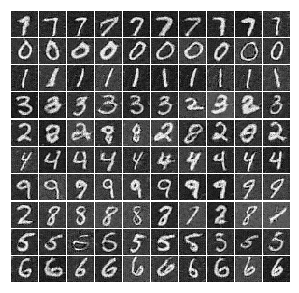

In [155]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)

for j, sample in enumerate(samples):
    ax = plt.subplot(gs[j])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

fig.savefig("result/A_class_3.png".format(0,0))

### Continuous Codes

##### c1

In [187]:
c1_numpy = np.zeros((100,10))

In [188]:
c1_numpy[:,0]=1

In [189]:
c2 = np.zeros(100)

In [190]:
start = -2.0
for i in range(10):
    c2[i*10:i*10+10] = start+ 4/9 * i

In [191]:
c3 = np.zeros(100)

In [192]:
noise = torch.FloatTensor(batchSize, nz, 1, 1)
noise.resize_(batchSize, nz).normal_(0, 1)

c1 = c1_numpy
c1 = torch.FloatTensor(c1)
c2 = torch.FloatTensor(c2.reshape((100,1)))
c2 = torch.FloatTensor(c2)
c3 = torch.FloatTensor(c3.reshape((100,1)))
c3 = torch.FloatTensor(c3)

c_disc = c1
c_cont = torch.cat([c2,c3],1)
c = torch.cat([c_disc,c_cont],1)

noisev = Variable(torch.cat([noise,c],1).cuda())

samples = netG(noisev).data.cpu().numpy()


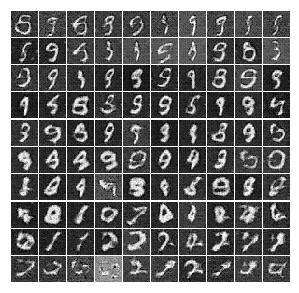

In [193]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)

for j, sample in enumerate(samples):
    ax = plt.subplot(gs[j])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

fig.savefig("result/A_conti_0.png".format(0,0))

##### c2

In [194]:
c1_numpy = np.zeros((100,10))

In [195]:
c1_numpy[:,0]=1

In [196]:
c2 = np.zeros(100)
c3 = np.zeros(100)

In [197]:
start = -2.0
for i in range(10):
    c3[i*10:i*10+10] = start+ 4/9 * i

In [198]:
noise = torch.FloatTensor(batchSize, nz, 1, 1)
noise.resize_(batchSize, nz).normal_(0, 1)

c1 = c1_numpy
c1 = torch.FloatTensor(c1)
c2 = torch.FloatTensor(c2.reshape((100,1)))
c2 = torch.FloatTensor(c2)
c3 = torch.FloatTensor(c3.reshape((100,1)))
c3 = torch.FloatTensor(c3)

c_disc = c1
c_cont = torch.cat([c2,c3],1)
c = torch.cat([c_disc,c_cont],1)

noisev = Variable(torch.cat([noise,c],1).cuda())

samples = netG(noisev).data.cpu().numpy()


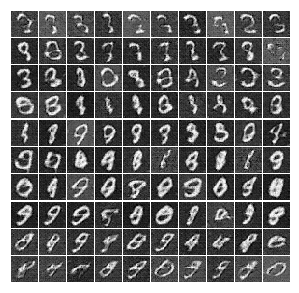

In [199]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)

for j, sample in enumerate(samples):
    ax = plt.subplot(gs[j])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

fig.savefig("result/A_conti_1.png".format(0,0))